In [1]:
# Take home project results
# Apr 2020
# Iman Haji, PhD

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
import gensim 
from gensim.models import Word2Vec
import seaborn as sns
import time
from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, accuracy_score, auc, classification_report 

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier


# I) Introduction
The goal is to make a classification based on a multitude of time-series datapoints from a variety of sensors as well as past weather outcomes (from https://www.kaggle.com/selfishgene/historical-hourly-weather-data). The desired classification outcome is: 
"Given historical weather data, can you predict whether tomorrow will be rainy in New York?". 
The project roadmap is shown below with the steps and methods that were considerd for this project. The check-marks highlight the steps that made it to the final cut:

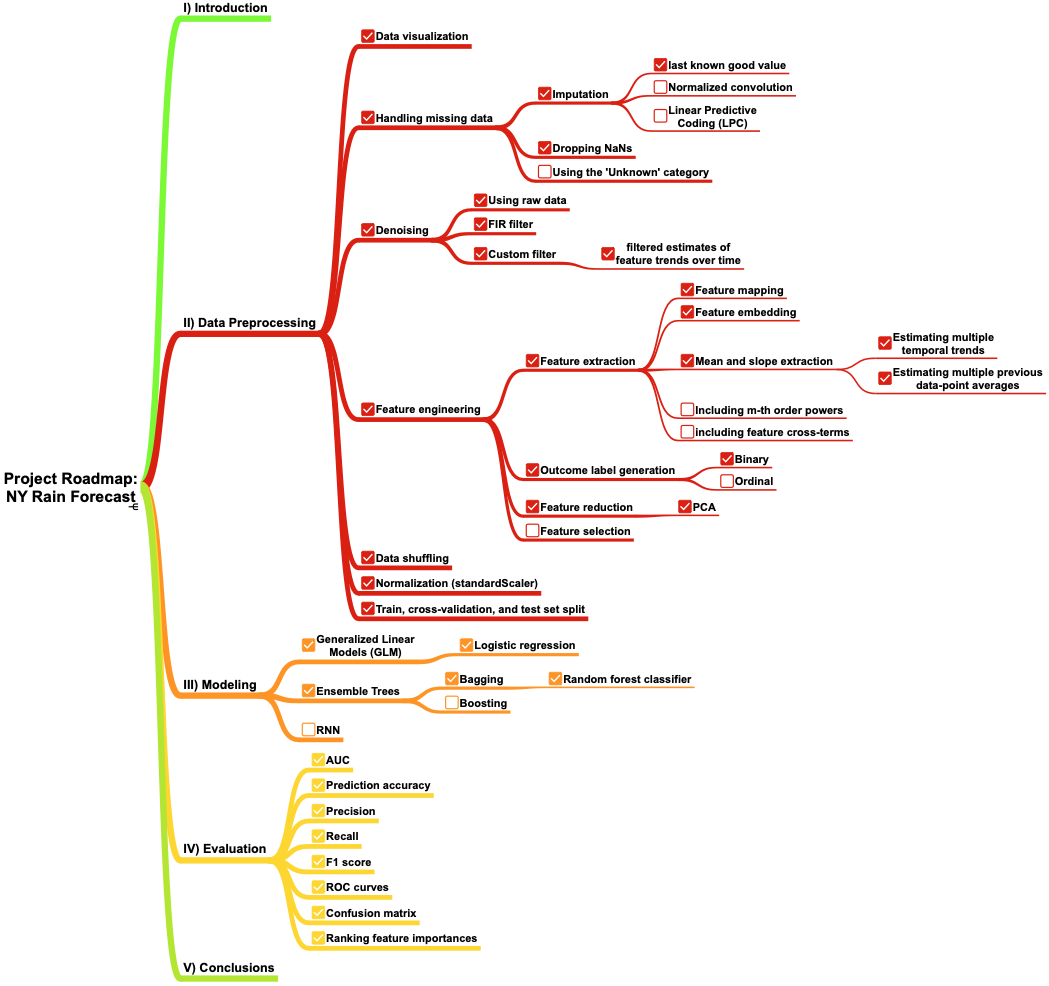

# II) Data Pre-Processing
Let's start by loading and visualizing a segment of the data:

## Loading datasets

In [4]:
# Extracting all New York data

humidity = pd.read_csv('humidity.csv')[['datetime', 'New York']]
pressure = pd.read_csv('pressure.csv')[['datetime', 'New York']]
temperature = pd.read_csv('temperature.csv')[['datetime', 'New York']]
wind_direction = pd.read_csv('wind_direction.csv')[['datetime', 'New York']]
wind_speed = pd.read_csv('wind_speed.csv')[['datetime', 'New York']]
weather_description = pd.read_csv('weather_description.csv')[['datetime', 'New York']]
city_attributes = pd.read_csv('city_attributes.csv')
city_attributes_ny = city_attributes[city_attributes['City'] == 'New York']

## Data Visualization

Text(0.5, 0, 'time (hours)')

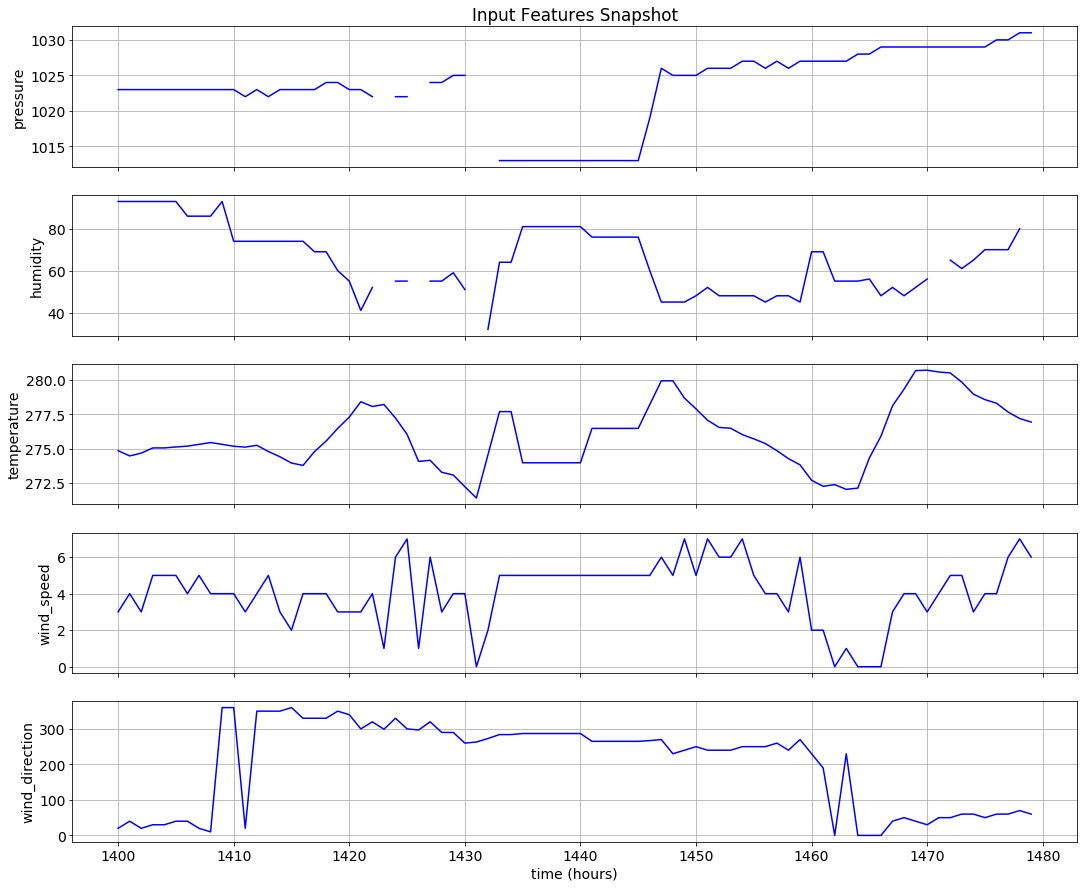

In [5]:
# Initial snapshot of data

plt.rcParams.update({'font.size': 14})
plt.rcParams['axes.grid'] = True
plot_range = np.arange(1400,1480)
fig, ax = plt.subplots(5,1, figsize = (18,15), sharex = True)

ax[0].plot(pressure['New York'].iloc[plot_range], 'b')
ax[1].plot(humidity['New York'].iloc[plot_range], 'b')
ax[2].plot(temperature['New York'].iloc[plot_range], 'b')
ax[3].plot(wind_speed['New York'].iloc[plot_range], 'b')
ax[4].plot(wind_direction['New York'].iloc[plot_range], 'b')

ax[0].set_title('Input Features Snapshot')

ax[0].set_ylabel('pressure')
ax[1].set_ylabel('humidity')
ax[2].set_ylabel('temperature')
ax[3].set_ylabel('wind_speed')
ax[4].set_ylabel('wind_direction')

ax[-1].set_xlabel('time (hours)')

Looks like there are missing data-points, especially for "pressure" and "humidity". Let's count the number of missing data-points in each dataset:

## Handling missing data

In [6]:
# counting NaNs in the datasets
def fast_nan_count(df):
    """
    Algorithm to quickly count the number of missing values
    """
    return len(df) - df.count()

print('\033[1m\033[94mtotal number of NaNs in the datasets:\033[0m')
print(f'pressure: {fast_nan_count(pressure["New York"])}')
print(f'humidity: {fast_nan_count(humidity["New York"])}')
print(f'temperature: {fast_nan_count(temperature["New York"])}')
print(f'wind_speed: {fast_nan_count(wind_speed["New York"])}')
print(f'wind_direction: {fast_nan_count(wind_direction["New York"])}')

total number of NaNs in the datasets:
pressure: 1041
humidity: 1624
temperature: 793
wind_speed: 793
wind_direction: 793


We may choose to drop the missing values, use normalized convolution to impute them, or use Linear Predictive Coding (LPC) to impute them using their past values. Since the majority of missing points are from the "pressure" and "humidity" datasets, and since these two are slow varying signals in hourly intervals, let's simply impute them using their last know value at each hour in time:

In [7]:
# Handling missing data
def last_known_good(input_array):
    """
    Function to impute missing data points with their last known good value in the time series
    """
    last_good_val = np.nan
    output_array = np.zeros(input_array.shape)
    for i in range(len(input_array)):
        if not np.isnan(input_array[i]):
            output_array[i] = input_array[i]
            last_good_val = input_array[i]
        else:
            output_array[i] = last_good_val
    return output_array

Let's run the imputation function on all data-sets and visualize the same segments of "pressure" and "humidity":

In [8]:
# Removing NaNs and preparing for table join

humidity['humidity'] = last_known_good(np.array(humidity['New York'])).reshape(-1,1)
pressure['pressure'] = last_known_good(np.array(pressure['New York'])).reshape(-1,1)
temperature['temperature'] = last_known_good(np.array(temperature['New York'])).reshape(-1,1)
wind_direction['wind_direction'] = last_known_good(np.array(wind_direction['New York'])).reshape(-1,1)
wind_speed['wind_speed'] = last_known_good(np.array(wind_speed['New York'])).reshape(-1,1)

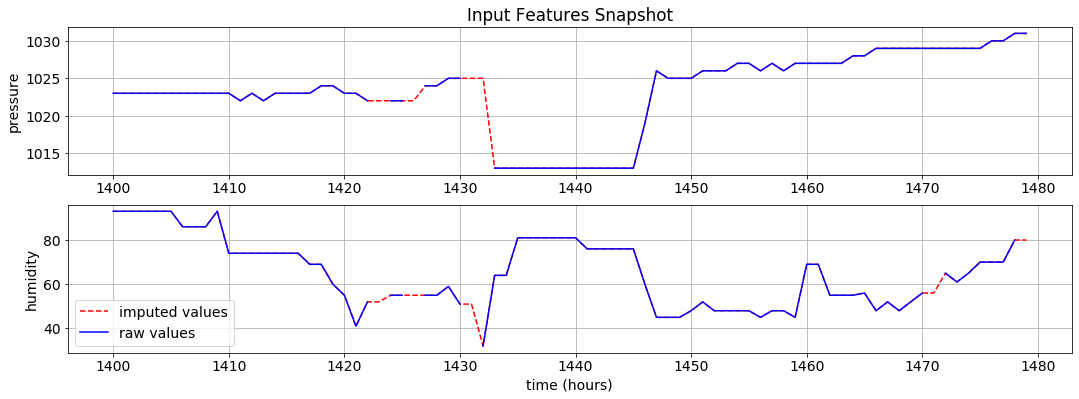

In [9]:
# Data visualization

plt.rcParams['axes.grid'] = True

fig, ax = plt.subplots(2,1, figsize = (18,6))

ax[0].plot(pressure['pressure'].iloc[plot_range], 'r--', label = 'imputed values')
ax[0].plot(pressure['New York'].iloc[plot_range], 'b', label = 'raw values')

ax[1].plot(humidity['humidity'].iloc[plot_range], 'r--', label = 'imputed values')
ax[1].plot(humidity['New York'].iloc[plot_range], 'b', label = 'raw values')

ax[0].set_title('Input Features Snapshot')

ax[0].set_ylabel('pressure')
ax[1].set_ylabel('humidity')

ax[-1].set_xlabel('time (hours)')

ax[-1].legend()

## Feature Engineering

### Feature extraction

### _Feature mapping_
A closer look at "wind_direction" in the first figure set reveals that its values are in degrees (angular) covering the range 0 to 359. The problem is that around angular directions of 359 and 0 we have chatter: even though the direction change between 359 and 0 is minimal, the numerical difference of the encoding of direction using angular degrees between the two is maximal. This could impact weight-based regression algorithms (e.g., Logistic Regression), as well as call for avoidable additional branchings of tree-based models etc.
To alleviate this issue, let's convert the angular direction to Cartesian coordinates, for which, the same problem does not exist. An additional benefit of the Cartesian coordinate is that it is automatically ~zero-mean and normalized between -1 and 1 for both dimensions. Here we do the conversion and visualize the results:

Text(0.5, 0, 'time (hours)')

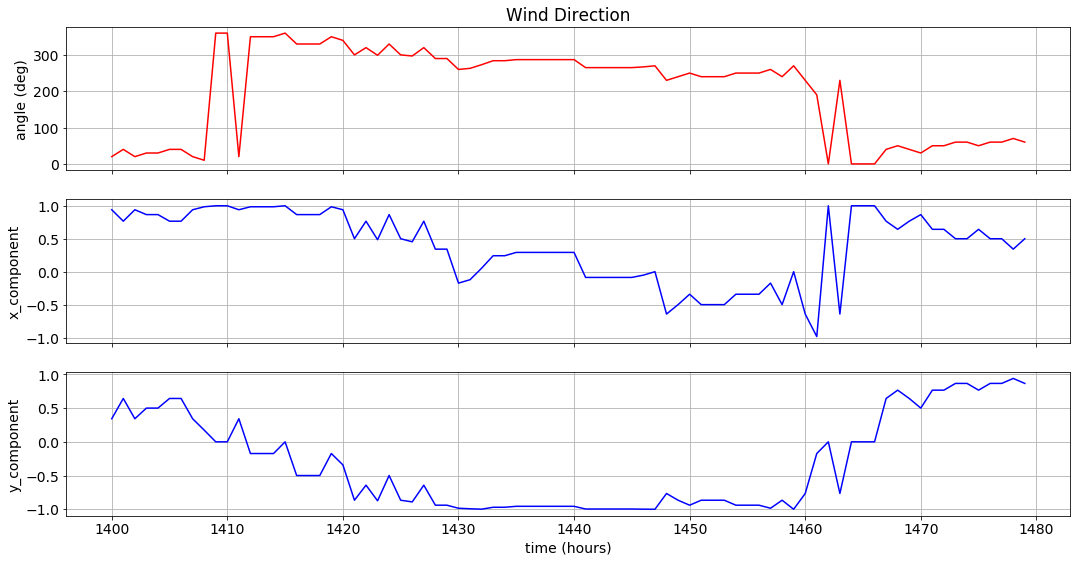

In [10]:
# converting wind direction to cartesian coordinates

def angle_to_cartesian_x(angle):
    """
    Maps wind direction angle to cartesian coordinates (x)
    """
    angle_radians = angle / 180 * np.pi
    return np.cos(angle_radians)

def angle_to_cartesian_y(angle):
    """
    Maps wind direction angle to cartesian coordinates (y)
    """
    angle_radians = angle / 180 * np.pi
    return np.sin(angle_radians)

wind_direction['wind_direction_x'] = wind_direction['wind_direction'].apply(angle_to_cartesian_x)
wind_direction['wind_direction_y'] = wind_direction['wind_direction'].apply(angle_to_cartesian_y)

fig, ax = plt.subplots(3,1, figsize = (18,9), sharex = True)
ax[0].plot(wind_direction['New York'].iloc[plot_range], 'r', label = 'angular direction') 
ax[0].set_title('Wind Direction')

ax[1].plot(wind_direction['wind_direction_x'].iloc[plot_range], 'b')

ax[2].plot(wind_direction['wind_direction_y'].iloc[plot_range], 'b')

ax[0].set_ylabel('angle (deg)')
ax[1].set_ylabel('x_component')
ax[2].set_ylabel('y_component')

ax[2].set_xlabel('time (hours)')


By converting the wind direction angle (top figure) to Cartesian (bottom two), the 0-359 chatter is gone.
Now let's inspect the outcome dataset. The outcomes have the string type, describing weather conditions:

In [11]:
print(weather_description['New York'].value_counts())

sky is clear                           11601
broken clouds                           6263
mist                                    5415
scattered clouds                        4595
overcast clouds                         4481
light rain                              4002
few clouds                              3329
fog                                     1085
moderate rain                            950
haze                                     691
light intensity drizzle                  408
light snow                               383
heavy intensity rain                     372
drizzle                                  224
heavy snow                               130
proximity thunderstorm                   114
snow                                      99
very heavy rain                           94
thunderstorm                              74
thunderstorm with light rain              36
dust                                      21
heavy intensity drizzle                   20
thundersto

### _Embedding weather conditions_
Even though the outcome seems categorical at the first glance, it appears to contain strong ordinality: 'moderate rain' seems synonumous to 'light rain', and they both seem closer in meaning to 'shower' compared to 'sand'!
Let's use an embedding layer to capture this ordinality. This has a couple of benefits:
A) meaningful dimensionality reduction (from 54 to a few, e.g., 5), and
B) enabling linear algebraic operations in the embedding layer, e.g., calculating the average vector of weather in a day or a month. For example, in this fashion, instead of recording 30 * 24 * 54 sparse one-hot encoded elements to handle monthly weather data, we can reduce the information to a few features (e.g., 5) by averaging the vectors in the embedding layer. Other vector aggregation options are also possible in the same way.

Let's train the embedding using NLP on the sequence of weather_conditions. To keep it fair, we will leave New York data out of the training of the emedding layer and use other cities in the dataset to develop the word corpus and sentences.

The method for extracting the embedding used here is Word2Vec - Continuous Bag of Words (CBOW):

In [12]:
# Training the weather condition embedding using sequence of data from other cities and the CBOW method

weather_other_cities = pd.read_csv('weather_description.csv').drop(['datetime', 'New York'], axis = 1).dropna()
corpus = [list(weather_other_cities[col]) for col in weather_other_cities.columns]

weather_embedding = gensim.models.Word2Vec(corpus, min_count = 1, size = 5, window = 20) 

The embedding model is trained. Now let's put our weather encoder to test:
#### Embedding experiment No. 1:

In [13]:
# Testing the embedding
print('\033[1m\033[94mConclusions:\033[0m')

sample_weather_condition = 'mist'
most_similar_word, similarity_score = weather_embedding.wv.most_similar(f'{sample_weather_condition}')[0]
print(f'"{sample_weather_condition}" is most similar to "{most_similar_word}" (similarity score = {similarity_score})')

sample_weather_condition = 'snow'
most_similar_word, similarity_score = weather_embedding.wv.most_similar(f'{sample_weather_condition}')[0]
print(f'"{sample_weather_condition}" is most similar to "{most_similar_word}" (similarity score = {similarity_score})')

sample_weather_condition = 'moderate rain'
most_similar_word, similarity_score = weather_embedding.wv.most_similar(f'{sample_weather_condition}')[0]
print(f'"{sample_weather_condition}" is most similar to "{most_similar_word}" (similarity score = {similarity_score})')


Conclusions:
"mist" is most similar to "fog" (similarity score = 0.9718993902206421)
"snow" is most similar to "light snow" (similarity score = 0.7084862589836121)
"moderate rain" is most similar to "light rain" (similarity score = 0.9288812875747681)


The results seem reasonable. Let's run a couple of more experiments on the embedding layer:
#### Embedding experiment No. 2:
I didn't know the meaning of the word "squalls" so I checked the most similar words to it (see below). I also referred to the Oxford online dictionary, which translates it as "a sudden violent gust of wind or a localized storm, especially one bringing rain, snow, or sleet". The translations seem to agree: 

In [14]:
print('\033[1m\033[94mWeather conditions similar to "\033[4msqualls\033[0m":')
weather_embedding.wv.most_similar('squalls')

Weather conditions similar to "squalls":


[('proximity thunderstorm', 0.9871722459793091),
 ('thunderstorm', 0.9733245968818665),
 ('thunderstorm with light rain', 0.9492741227149963),
 ('thunderstorm with rain', 0.8899540901184082),
 ('thunderstorm with heavy rain', 0.7972507476806641),
 ('dust', 0.7261936068534851),
 ('sleet', 0.6882535219192505),
 ('smoke', 0.6850711703300476),
 ('thunderstorm with light drizzle', 0.6844556927680969),
 ('shower rain', 0.6708961725234985)]

#### Embedding experiment No. 3:
Let's try linear algebraic operations in the embedding layer. To do our classification we first need to define "rainy" as it is going to be our outcome positive label. We will first define outcomes that are "rainy" and then average them on the embedding layer:

In [15]:
# defining the rainy label

rainy_conditions = [condition for condition in weather_embedding.wv.index2word if \
                  ((('rain' in condition) or ('shower' in condition))\
                   and ('snow' not in condition))]
print('\033[1m\033[94mOutcomes considered as "rainy", i.e., positive outcome:\033[0m')
print(rainy_conditions)

Outcomes considered as "rainy", i.e., positive outcome:
['light rain', 'moderate rain', 'heavy intensity rain', 'light intensity shower rain', 'proximity shower rain', 'thunderstorm with light rain', 'very heavy rain', 'thunderstorm with rain', 'thunderstorm with heavy rain', 'shower rain', 'proximity thunderstorm with rain', 'freezing rain', 'light intensity drizzle rain', 'heavy intensity shower rain', 'light shower sleet', 'proximity moderate rain', 'ragged shower rain', 'shower drizzle']


Now let's vector-average the embeddings of weather conditions that we have selected as indicators of rain, and see which word is closest to that average in our weather conditions dictionary:

In [16]:
average_rainy_condition = weather_embedding.wv.similar_by_vector(np.mean(
                np.array([weather_embedding.wv.get_vector(condition)\
                for condition in rainy_conditions]), axis = 0))
print('\033[1m\033[94mConclusion:\033[0m')
print(f"the condition closest to the average of all the rainy conditions in the \nembedding layer and its likelihood are: {average_rainy_condition[0]}")

Conclusion:
the condition closest to the average of all the rainy conditions in the 
embedding layer and its likelihood are: ('ragged shower rain', 0.9896754622459412)


### _Mean and slope extraction_
Here we are dealing with a lot of time points and another meaningful feature reduction approach sounds helpful. For instance, if we want to use the feature histories from the past 3 months to predict the weather for tomorrow, we have 3 *  30 * 24 * 5 features for training! We only have around 45K training rows for New York which is not sufficient to train such a high volume of input features.
Another method we will use for feature reduction is the extraction of mean and trend (slope) from the features. Since we would like to put more emphasis on more recent data-points (i.e., closer to prediction time) we will estimate the mean and slope on look-back time intervals that are more densely populated at the proximity of the prediction time. For determining the look-back observation window lengths, we will use power series. The total of 12 look-back windows will be considered. Each of these windows will capture data from the moment of prediction to N hours before prediction. 
#### Inherent low-pass filtering
This approach combines feature reduction and data low-pass filtering at the same time, as averaging and slope estimation over multiple samples are low-pass processes. Here we have a set of values for N (the look-back depths):

In [17]:
# we are going to calculate the mean and derivative of features for these time windows from prediction time:

window_lengths = np.power(2, np.arange(12))

print('\033[1m\033[94mWindow look-back lengths (in hours) from the prediction point:\033[0m')
print(window_lengths, '\n')

Window look-back lengths (in hours) from the prediction point:
[   1    2    4    8   16   32   64  128  256  512 1024 2048] 



Let's implement linear regression as well as a function to apply it over multiple columns in dataframes for all look-back windows:

In [18]:
# estimating trends from a list of consecutive observations (linear regression)

def mean_and_slope_est(Y):
    """
    Linear regression: this function returns the mean and slope from a series of consecutive values
    """
    if len(Y) == 0:
        return np.nan, np.nan
    X = np.arange(len(Y))
    cov_matrix = np.cov(X,Y, bias=True)
    slope = cov_matrix[0,1] / cov_matrix[0,0]
    mean = np.mean(Y)
    return mean, slope


In [19]:
def feature_generator(input_df, columns, window_lengths):
    """
    This function generates all mean and slope features for all look-back window lenghts 
    on all desired columns in the dataframe
    """
    for current_column in columns:
        if 1 in window_lengths:
            input_df[current_column + '_mean_1'] = input_df[current_column]
        for winlen in [winlen for winlen in window_lengths if winlen !=1]:
            mean_list = []
            slope_list = []
            for i in range(input_df.shape[0]):
                win_start_index = i - winlen + 1
                win_end_index = i + 1
                data_segment = input_df[current_column].iloc[win_start_index:win_end_index]
                current_mean, current_slope = mean_and_slope_est(data_segment)
                mean_list.append(current_mean)
                slope_list.append(current_slope)
            input_df[current_column + f'_mean_{winlen}'] = np.array(mean_list)
            input_df[current_column + f'_slope_{winlen}'] = np.array(slope_list)
    return input_df


Finally, we will extract the desired mean/slope features for all input features at all timestamps (warning: this process takes ~30 minutes to complete):

In [20]:
#Generating engineered features for all attributes

start = time.time()

humidity = feature_generator(humidity, ['humidity'], window_lengths) 
pressure = feature_generator(pressure, ['pressure'], window_lengths) 
temperature = feature_generator(temperature, ['temperature'], window_lengths) 
wind_speed = feature_generator(wind_speed, ['wind_speed'], window_lengths) 
wind_direction = feature_generator(wind_direction, ['wind_direction_x'], window_lengths) 
wind_direction = feature_generator(wind_direction, ['wind_direction_y'], window_lengths) 

end = time.time()
print(f'Features extracted in {end - start} seconds')

Features extracted in 915.1862399578094 seconds


Next we will generate the weather embedding column using the embedding model we have already trained. These embedded past values of "weather_condition" will also serve as input features to our classifier (in an autoregressive fashion):

In [21]:
def embedding_column_gen(weather_df, column, weather_embedding):
    embedding_dims = weather_embedding.trainables.layer1_size
    embedded_array = np.array([[np.nan]*embedding_dims if type(i) != str else \
                               weather_embedding.wv.get_vector(i) for i in weather_df[column]])
    for dim in range(embedding_dims):
        weather_df[f'weather_dim_{dim}'] = embedded_array[:,dim]
    return weather_df

Now that the output is vectorized in a meaningful fashion, let's also extract all mean and slopes for the embedded outcome over the previously specified look-back windows as well:

In [22]:
weather_description = embedding_column_gen(weather_description, 'New York', weather_embedding)
feature_columns = [col for col in weather_description.columns if col not in ['datetime', 'New York']]
start = time.time()
weather_description = feature_generator(weather_description, feature_columns, window_lengths) 
end = time.time()
print(f'Features extracted in {end - start} seconds')

Features extracted in 750.5104699134827 seconds


In [23]:
weather_description.iloc[2200:2203]

,datetime,New York,weather_dim_0,weather_dim_1,weather_dim_2,weather_dim_3,weather_dim_4,weather_dim_0_mean_1,weather_dim_0_mean_2,weather_dim_0_slope_2,...,weather_dim_4_mean_128,weather_dim_4_slope_128,weather_dim_4_mean_256,weather_dim_4_slope_256,weather_dim_4_mean_512,weather_dim_4_slope_512,weather_dim_4_mean_1024,weather_dim_4_slope_1024,weather_dim_4_mean_2048,weather_dim_4_slope_2048
2200,2013-01-01 04:00:00,sky is clear,1.636288,0.012255,-7.699513,-0.677426,-1.556937,1.636288,-2.859643,8.991862,...,2.686145,-0.002637,2.433604,0.002628,1.547594,0.005332,1.433144,0.000263,1.385382,0.000221
2201,2013-01-01 05:00:00,sky is clear,1.636288,0.012255,-7.699513,-0.677426,-1.556937,1.636288,1.636288,0.000000,...,2.651469,-0.004107,2.416266,0.002305,1.548592,0.005179,1.429705,0.000249,1.383214,0.000219
2202,2013-01-01 06:00:00,sky is clear,1.636288,0.012255,-7.699513,-0.677426,-1.556937,1.636288,1.636288,0.000000,...,2.598698,-0.004696,2.398928,0.001986,1.551716,0.005000,1.426266,0.000235,1.381495,0.000216


'Time' is also an important feature that could enhance the weather prediction power. Let's split the timestamp to year, month, and day to have more meaningful dimensions. Theoretically we can only extract time (in hours) from the timestamp. However, splitting based on year, month, and day may capture the seasonal attributes more effectively:

In [24]:
# Now converting datetime to separate, year, month, and day columns to allow for yearly, seasonal, monthly
# daily and even hourly temporal features to be represented

datetime_df = weather_description[['datetime']].copy()
datetime_df['time_stamp'] = datetime_df['datetime'].apply(pd.Timestamp)
datetime_df['year'] = datetime_df['time_stamp'].apply(lambda timestamp: timestamp.year)
datetime_df['month'] = datetime_df['time_stamp'].apply(lambda timestamp: timestamp.month)
datetime_df['day'] = datetime_df['time_stamp'].apply(lambda timestamp: timestamp.day)
datetime_df['hour'] = datetime_df['time_stamp'].apply(lambda timestamp: timestamp.hour)

## Outcome label generation

The goal here is to determine if the next day is going to be "rainy". We have already defined the list of conditions that are considered "rainy" and here we will look at the future time points, to see if it will be "rainy" in the next 24 hours at each time point. The outcomes will serve as our train/cross-validation/test labels:

In [25]:
# Generating the outcome features

def binary_outcome_gen(weather_description_df, 
                       pos_outcome_list,
                       input_column, 
                       output_column_name):
    """
    Generates outcome True/False labels based on weather conditions in the next day relative to each timestamp.
    True means "it will rain", and False means "it won't rain".
    """
    output = []
    for i in range(weather_description_df.shape[0]):
        current_outcomes = list(weather_description_df[input_column].iloc[i+1: i+25])
        current_output = (len([outcome for outcome in current_outcomes if outcome in pos_outcome_list])) > 0
        output.append(current_output)

    weather_description_df[output_column_name] = np.array(output)
    return weather_description_df
        

Let's run the labeling algorithm and evaluate the distributin of outcome labels:

In [26]:
weather_description = binary_outcome_gen(weather_description, 
                       rainy_conditions,
                       'New York', 
                       'label')
print('\033[1m\033[94mCount of positive and negative labels:\033[0m')
print(weather_description['label'].value_counts())

Count of positive and negative labels:
True     25668
False    19585
Name: label, dtype: int64


### Joining all features and the outcome label to produce the model_ready table
Finally, let's put all the features together in a unified dataframe and drop the remaining NaNs to prepare for data shuffling, splitting, and model training:

In [27]:
# Feature columns to include in the model ready table
datetime_features = ['year', 'month', 'day', 'hour']
humidity_features = [col for col in humidity.columns if ('mean' in col) or ('slope' in col)]
pressure_features = [col for col in pressure.columns if ('mean' in col) or ('slope' in col)]
temperature_features = [col for col in temperature.columns if ('mean' in col) or ('slope' in col)]
wind_direction_features = [col for col in wind_direction.columns if ('mean' in col) or ('slope' in col)]
wind_speed_features = [col for col in wind_speed.columns if ('mean' in col) or ('slope' in col)]
weather_description_features = [col for col in weather_description.columns if ('mean' in col)] + ['label']

model_ready_df = pd.concat([datetime_df[datetime_features],
                            humidity[humidity_features],
                            pressure[pressure_features],
                            temperature[temperature_features],
                            wind_direction[wind_direction_features],
                            wind_speed[wind_speed_features],
                            weather_description[weather_description_features]
                           ], axis = 1).dropna().reset_index(drop = True)

Here are the list of final model features. Note that we are also including past values of weather_condition (embedded) as input features for prediction (a variation of auto-regressive prediction):

In [28]:
print(f'\033[1m\033[94mFinal list of features:\033[0m')
list(model_ready_df.columns[:-1])

Final list of features:


['year',
 'month',
 'day',
 'hour',
 'humidity_mean_1',
 'humidity_mean_2',
 'humidity_slope_2',
 'humidity_mean_4',
 'humidity_slope_4',
 'humidity_mean_8',
 'humidity_slope_8',
 'humidity_mean_16',
 'humidity_slope_16',
 'humidity_mean_32',
 'humidity_slope_32',
 'humidity_mean_64',
 'humidity_slope_64',
 'humidity_mean_128',
 'humidity_slope_128',
 'humidity_mean_256',
 'humidity_slope_256',
 'humidity_mean_512',
 'humidity_slope_512',
 'humidity_mean_1024',
 'humidity_slope_1024',
 'humidity_mean_2048',
 'humidity_slope_2048',
 'pressure_mean_1',
 'pressure_mean_2',
 'pressure_slope_2',
 'pressure_mean_4',
 'pressure_slope_4',
 'pressure_mean_8',
 'pressure_slope_8',
 'pressure_mean_16',
 'pressure_slope_16',
 'pressure_mean_32',
 'pressure_slope_32',
 'pressure_mean_64',
 'pressure_slope_64',
 'pressure_mean_128',
 'pressure_slope_128',
 'pressure_mean_256',
 'pressure_slope_256',
 'pressure_mean_512',
 'pressure_slope_512',
 'pressure_mean_1024',
 'pressure_slope_1024',
 'pressur

### Checkpoint

In [29]:
# model_ready_df.to_csv('model_ready_df.csv', index = False)
# model_ready_df = pd.read_csv('model_ready_df.csv')

### Shuffling and train-test-splitting

Let's keep a third of the data aside as the test set. We won't touch this dataset during training or cross-validation:

In [30]:
# Shuffling the data and keeping a separate test set for unbiased scoring

X_train, X_test, y_train, y_test = train_test_split(model_ready_df.drop('label', axis = 1),
                                                    model_ready_df['label'],
                                                    test_size=0.33,
                                                    shuffle = True)


# III) Modeling

As our base classification model we will use Logistic Regression (LGR). The pre-processing here consists of StandardScaling (normalization) of the input features, as well as the Principal Component Analysis (PCA) for dimensionality reduction. The reason for further dimensionality reduction is enhancing processing speed (we have ~200 features and we will try to reduce them to save time especially for the next classifier model) as well as potential useful noise reduction and regularization. Here we are hyper-parameter tuning through cross-validation for the regularization coefficient of the LGR, as well the number of PCA dimensions:

## Logistic Regression

In [31]:
# Defining the pipeline
pipeline = Pipeline(steps=[('scl', StandardScaler()),
                           ('pca', PCA()),
                           ('lgr', linear_model.LogisticRegression(solver = 'liblinear'))])
# Cross validation
pca__n_components = [70, 100, 130, X_train.shape[1]]
lgr__C = np.logspace(-6, 3, 10)
parameters = dict(pca__n_components=pca__n_components,
                  lgr__C = lgr__C)

# Scoring
scoring = {'AUC': make_scorer(roc_auc_score),
           'Accuracy': make_scorer(accuracy_score),
           'Precision': make_scorer(precision_score),
           'Recall': make_scorer(recall_score),
           'F1': make_scorer(f1_score)}

model = GridSearchCV(pipeline, 
                     parameters, 
                     cv = StratifiedKFold(n_splits=3),
                     refit='AUC',
                     scoring = scoring,
                     return_train_score=True)

model.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scl',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('lgr',
                                        LogisticRegres...
             param_grid={'lgr__C': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-

We will evaluate model performance on the test set on multiple splits to extract model performance statistics:

In [32]:
# K-split evaluation of the model accuracy metrics on the 'unseen' test set

def k_split_test_set_evaluation(estimator, evaluator_dict, X_test, y_test, no_of_splits):
    """
    This function evaluates the test set on multiple splits to extract statistics for accuracy
    (similar to K-Fold cross validation but without further training)
    """
    y_pred = estimator.predict(X_test)
    N = X_test.shape[0]
    split_size = int(N / no_of_splits)
    split_indexes = np.arange(0, N, split_size)
    evaluation_metrics = evaluator_dict.keys()
    results_list = []
    for i in range(len(split_indexes) - 1):
        current_results = []
        for eval_metric in evaluation_metrics:
            current_eval = evaluator_dict[eval_metric](y_test[split_indexes[i]: split_indexes[i+1]],
                                                      y_pred[split_indexes[i]: split_indexes[i+1]])
            current_results.append(current_eval)
        results_list.append(current_results)
    results_df = pd.DataFrame(np.array(results_list), columns = evaluation_metrics)
    return results_df
            
evaluator_dict = {'AUC': roc_auc_score,
                   'Accuracy': accuracy_score,
                   'Precision': precision_score,
                   'Recall': recall_score,
                   'F1': f1_score}

test_set_results = k_split_test_set_evaluation(model, evaluator_dict, X_test, y_test, 4)

Finally, let's look at classification results for LGR:

In [33]:
# Classification Results
print('\033[1m\033[94mLOGISTIC REGRESSION CLASSIFICATION RESULTS\033[0m')
print(f'the optimal detected parameters are: {model.best_params_}')
print('\n')
print('\033[1mTEST SET RESULTS FOR THE OPTIMAL HYPER-PARAMETERS:\033[0m')
print(f'''   AUC = {test_set_results.mean(axis = 0)['AUC']: .2f} ± {test_set_results.std(axis = 0)['AUC']: .3f}''')
print(f'''   Accuracy = {test_set_results.mean(axis = 0)['Accuracy']: .2f} ± {test_set_results.std(axis = 0)['Accuracy']: .3f}''')
print(f'''   Precision = {test_set_results.mean(axis = 0)['Precision']: .2f} ± {test_set_results.std(axis = 0)['Precision']: .3f}''')
print(f'''   Recall = {test_set_results.mean(axis = 0)['Recall']: .2f} ± {test_set_results.std(axis = 0)['Recall']: .3f}''')
print(f'''   F1 = {test_set_results.mean(axis = 0)['F1']: .2f} ± {test_set_results.std(axis = 0)['F1']: .3f}''')
print('\n')
print('\033[1mCV SET RESULTS FOR THE OPTIMAL HYPER-PARAMETERS:\033[0m')
print(f'''   AUC = {model.cv_results_['mean_test_AUC'][model.best_index_]: .2f} ± {model.cv_results_['std_test_AUC'][model.best_index_]: .3f}''')
print(f'''   Accuracy = {model.cv_results_['mean_test_Accuracy'][model.best_index_]: .2f} ± {model.cv_results_['std_test_Accuracy'][model.best_index_]: .3f}''')
print(f'''   Precision = {model.cv_results_['mean_test_Precision'][model.best_index_]: .2f} ± {model.cv_results_['std_test_Precision'][model.best_index_]: .3f}''')
print(f'''   Recall = {model.cv_results_['mean_test_Recall'][model.best_index_]: .2f} ± {model.cv_results_['std_test_Recall'][model.best_index_]: .3f}''')
print(f'''   F1 = {model.cv_results_['mean_test_F1'][model.best_index_]: .2f} ± {model.cv_results_['std_test_F1'][model.best_index_]: .3f}''')
print('\n')
print('\033[1mTRAIN SET RESULTS FOR THE OPTIMAL HYPER-PARAMETERS:\033[0m')
print(f'''   AUC = {model.cv_results_['mean_train_AUC'][model.best_index_]: .2f} ± {model.cv_results_['std_train_AUC'][model.best_index_]: .3f}''')
print(f'''   Accuracy = {model.cv_results_['mean_train_Accuracy'][model.best_index_]: .2f} ± {model.cv_results_['std_train_Accuracy'][model.best_index_]: .3f}''')
print(f'''   Precision = {model.cv_results_['mean_train_Precision'][model.best_index_]: .2f} ± {model.cv_results_['std_train_Precision'][model.best_index_]: .3f}''')
print(f'''   Recall = {model.cv_results_['mean_train_Recall'][model.best_index_]: .2f} ± {model.cv_results_['std_train_Recall'][model.best_index_]: .3f}''')
print(f'''   F1 = {model.cv_results_['mean_train_F1'][model.best_index_]: .2f} ± {model.cv_results_['std_train_F1'][model.best_index_]: .3f}''')

LOGISTIC REGRESSION CLASSIFICATION RESULTS
the optimal detected parameters are: {'lgr__C': 100.0, 'pca__n_components': 202}


TEST SET RESULTS FOR THE OPTIMAL HYPER-PARAMETERS:
   AUC =  0.74 ±  0.008
   Accuracy =  0.76 ±  0.009
   Precision =  0.78 ±  0.010
   Recall =  0.81 ±  0.010
   F1 =  0.80 ±  0.010


CV SET RESULTS FOR THE OPTIMAL HYPER-PARAMETERS:
   AUC =  0.74 ±  0.007
   Accuracy =  0.75 ±  0.006
   Precision =  0.78 ±  0.006
   Recall =  0.81 ±  0.004
   F1 =  0.79 ±  0.005


TRAIN SET RESULTS FOR THE OPTIMAL HYPER-PARAMETERS:
   AUC =  0.75 ±  0.002
   Accuracy =  0.76 ±  0.002
   Precision =  0.78 ±  0.002
   Recall =  0.81 ±  0.002
   F1 =  0.80 ±  0.001


In [34]:
# Confusion matrix:
print('\033[1m\033[94mConfusion matrix for the Logistic Regression Classifier:\033[0m')
print(pd.DataFrame(confusion_matrix(y_test, model.predict(X_test)), 
             index = ['Detected Neg', 'Detected Pos'],
             columns = ['Actual Neg', 'Actual Pos']))

Confusion matrix for the Logistic Regression Classifier:
              Actual Neg  Actual Pos
Detected Neg        3866        1898
Detected Pos        1523        6710


We have tested the model accuracy during trainig, CV, and testing using the following metrics:
Area Under the ROC Curve (AUC), classification accuracy, precision, recall, and F1 score.
As can be seen above, the results are reasonable: AUC = 0.75 on the test set.
Let's train our next model and then compare the two models in depth:
For the second model, let's try the random forest classifier - a bagging algorithm:


## Random Forest Classifier

Here, again we have the StandardScaler, as well as PCA to reduce dimensionality as well as. The hyper-parameters that are chosen to be tuned are number of PCA components, number of RF estimator trees, and the max depth of RF (both also having regularization effects on the RF):

In [35]:
# Defining the pipeline
pipeline2 = Pipeline(steps=[('scl', StandardScaler()),
                           ('pca', PCA()),
                           ('rf', RandomForestClassifier())])

# Cross validation
pca__n_components = [30, 40]
rf__n_estimators = [int(i) for i in np.linspace(100, 200, 3)]
rf__max_depth = [int(x) for x in np.linspace(10, 30, 3)]
parameters2 = {'pca__n_components' : pca__n_components,
              'rf__n_estimators': rf__n_estimators,
              'rf__max_depth': rf__max_depth,
              }

# Other hyper-parameters to tune - increases computational time

# rf__max_features = ['auto', 'sqrt']
# rf__min_samples_split = [2, 5, 10]
# rf__min_samples_leaf = [1, 2, 4]
# rf__bootstrap = [True, False]
# parameters2 = {'pca__n_components' = pca__n_components
#               'rf__n_estimators': rf__n_estimators,
#               'rf__max_depth': rf__max_depth,
#               'rf__max_features': rf__max_features,               
#               'rf__min_samples_split': rf__min_samples_split,
#               'rf__min_samples_leaf': rf__min_samples_leaf,
#               'rf__bootstrap': rf__bootstrap}

# Scoring
scoring = {'AUC': make_scorer(roc_auc_score),
           'Accuracy': make_scorer(accuracy_score),
           'Precision': make_scorer(precision_score),
           'Recall': make_scorer(recall_score),
           'F1': make_scorer(f1_score),
          }

model2 = GridSearchCV(pipeline2, 
                     parameters2, 
                     cv = StratifiedKFold(n_splits=3),
                     refit='AUC',
                     scoring = scoring,
                     return_train_score=True
                    )
model2.fit(X_train, 
           y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scl',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('rf',
                                        RandomForestCla...
             param_grid={'pca__n_components': [30, 40],
                         'rf__

Again, we evaluate the test set on multiple splits to extract statistics on model performance. The final results for the RF classifier are generated below:

In [36]:
# K-split evaluation of the model accuracy metrics on the 'unseen' test set
test_set_results2 = k_split_test_set_evaluation(model2, evaluator_dict, X_test, y_test, 4)


In [37]:
# Classification Results
print('\033[1m\033[94mRANDOM FOREST CLASSIFICATION RESULTS\033[0m')
print(f'the optimal detected parameters are: {model2.best_params_}')
print('\n')
print('\033[1mTEST SET RESULTS FOR THE OPTIMAL HYPER-PARAMETERS:\033[0m')
print(f'''   AUC = {test_set_results2.mean(axis = 0)['AUC']: .2f} ± {test_set_results2.std(axis = 0)['AUC']: .3f}''')
print(f'''   Accuracy = {test_set_results2.mean(axis = 0)['Accuracy']: .2f} ± {test_set_results2.std(axis = 0)['Accuracy']: .3f}''')
print(f'''   Precision = {test_set_results2.mean(axis = 0)['Precision']: .2f} ± {test_set_results2.std(axis = 0)['Precision']: .3f}''')
print(f'''   Recall = {test_set_results2.mean(axis = 0)['Recall']: .2f} ± {test_set_results2.std(axis = 0)['Recall']: .3f}''')
print(f'''   F1 = {test_set_results2.mean(axis = 0)['F1']: .2f} ± {test_set_results2.std(axis = 0)['F1']: .3f}''')
print('\n')
print('\033[1mCV SET RESULTS FOR THE OPTIMAL HYPER-PARAMETERS:\033[0m')
print(f'''   AUC = {model2.cv_results_['mean_test_AUC'][model2.best_index_]: .2f} ± {model2.cv_results_['std_test_AUC'][model2.best_index_]: .3f}''')
print(f'''   Accuracy = {model2.cv_results_['mean_test_Accuracy'][model2.best_index_]: .2f} ± {model2.cv_results_['std_test_Accuracy'][model2.best_index_]: .3f}''')
print(f'''   Precision = {model2.cv_results_['mean_test_Precision'][model2.best_index_]: .2f} ± {model2.cv_results_['std_test_Precision'][model2.best_index_]: .3f}''')
print(f'''   Recall = {model2.cv_results_['mean_test_Recall'][model2.best_index_]: .2f} ± {model2.cv_results_['std_test_Recall'][model2.best_index_]: .3f}''')
print(f'''   F1 = {model2.cv_results_['mean_test_F1'][model2.best_index_]: .2f} ± {model2.cv_results_['std_test_F1'][model2.best_index_]: .3f}''')
print('\n')
print('\033[1mTRAIN SET RESULTS FOR THE OPTIMAL HYPER-PARAMETERS:\033[0m')
print(f'''   AUC = {model2.cv_results_['mean_train_AUC'][model2.best_index_]: .2f} ± {model2.cv_results_['std_train_AUC'][model2.best_index_]: .3f}''')
print(f'''   Accuracy = {model2.cv_results_['mean_train_Accuracy'][model2.best_index_]: .2f} ± {model2.cv_results_['std_train_Accuracy'][model2.best_index_]: .3f}''')
print(f'''   Precision = {model2.cv_results_['mean_train_Precision'][model2.best_index_]: .2f} ± {model2.cv_results_['std_train_Precision'][model2.best_index_]: .3f}''')
print(f'''   Recall = {model2.cv_results_['mean_train_Recall'][model2.best_index_]: .2f} ± {model2.cv_results_['std_train_Recall'][model2.best_index_]: .3f}''')
print(f'''   F1 = {model2.cv_results_['mean_train_F1'][model2.best_index_]: .2f} ± {model2.cv_results_['std_train_F1'][model2.best_index_]: .3f}''')

RANDOM FOREST CLASSIFICATION RESULTS
the optimal detected parameters are: {'pca__n_components': 30, 'rf__max_depth': 30, 'rf__n_estimators': 200}


TEST SET RESULTS FOR THE OPTIMAL HYPER-PARAMETERS:
   AUC =  0.92 ±  0.004
   Accuracy =  0.93 ±  0.003
   Precision =  0.91 ±  0.006
   Recall =  0.98 ±  0.001
   F1 =  0.94 ±  0.003


CV SET RESULTS FOR THE OPTIMAL HYPER-PARAMETERS:
   AUC =  0.90 ±  0.005
   Accuracy =  0.91 ±  0.004
   Precision =  0.89 ±  0.004
   Recall =  0.96 ±  0.003
   F1 =  0.93 ±  0.004


TRAIN SET RESULTS FOR THE OPTIMAL HYPER-PARAMETERS:
   AUC =  1.00 ±  0.000
   Accuracy =  1.00 ±  0.000
   Precision =  1.00 ±  0.000
   Recall =  1.00 ±  0.000
   F1 =  1.00 ±  0.000


In [38]:
# Confusion matrix:
print('\033[1m\033[94mConfusion matrix for the Random Forest Classifier:\033[0m')
print(pd.DataFrame(confusion_matrix(y_test, model2.predict(X_test)), 
             index = ['Detected Neg', 'Detected Pos'],
             columns = ['Actual Neg', 'Actual Pos']))

Confusion matrix for the Random Forest Classifier:
              Actual Neg  Actual Pos
Detected Neg        5017         747
Detected Pos         203        8030


# IV) Evaluation

All of our metrics clearly demostrate significant performance improvement for the Rf classifier over LGR on all the test/CV/train sets. The training AUC score of the LGR was around 0.75 which hints to a bias limitation for LGR. However, due to the flexibility of RF in capturing non-linearities and feature interactions, the model has minimal bias limitations. In fact, the optimal hyper-parameter set that maximizes the CV accuracy, fit the training set almost perfectly. With the addition of more data, the cross validation score may very well approach the trainig score even more. The minimal bias of the algorithm suggests the sufficiency of model complexity to capture the training data non-linearities.
The AUC of the RF on test set is an impressive 0.92. The precision is 0.91, while recall is at 0.97. Let's look at both model summaries for LGR and RF as well as the ROC curves:

In [39]:
# Classification Summary:
print('\033[1m\033[94mClassification summary for the Logistic Regression Classifier:\033[0m')
print(classification_report(y_test, model.predict(X_test)))
print('\n')
print('\033[1m\033[94mClassification summary for the Random Forest Classifier:\033[0m')
print(classification_report(y_test, model2.predict(X_test)))


Classification summary for the Logistic Regression Classifier:
              precision    recall  f1-score   support

       False       0.72      0.67      0.69      5764
        True       0.78      0.82      0.80      8233

    accuracy                           0.76     13997
   macro avg       0.75      0.74      0.75     13997
weighted avg       0.75      0.76      0.75     13997



Classification summary for the Random Forest Classifier:
              precision    recall  f1-score   support

       False       0.96      0.87      0.91      5764
        True       0.91      0.98      0.94      8233

    accuracy                           0.93     13997
   macro avg       0.94      0.92      0.93     13997
weighted avg       0.93      0.93      0.93     13997



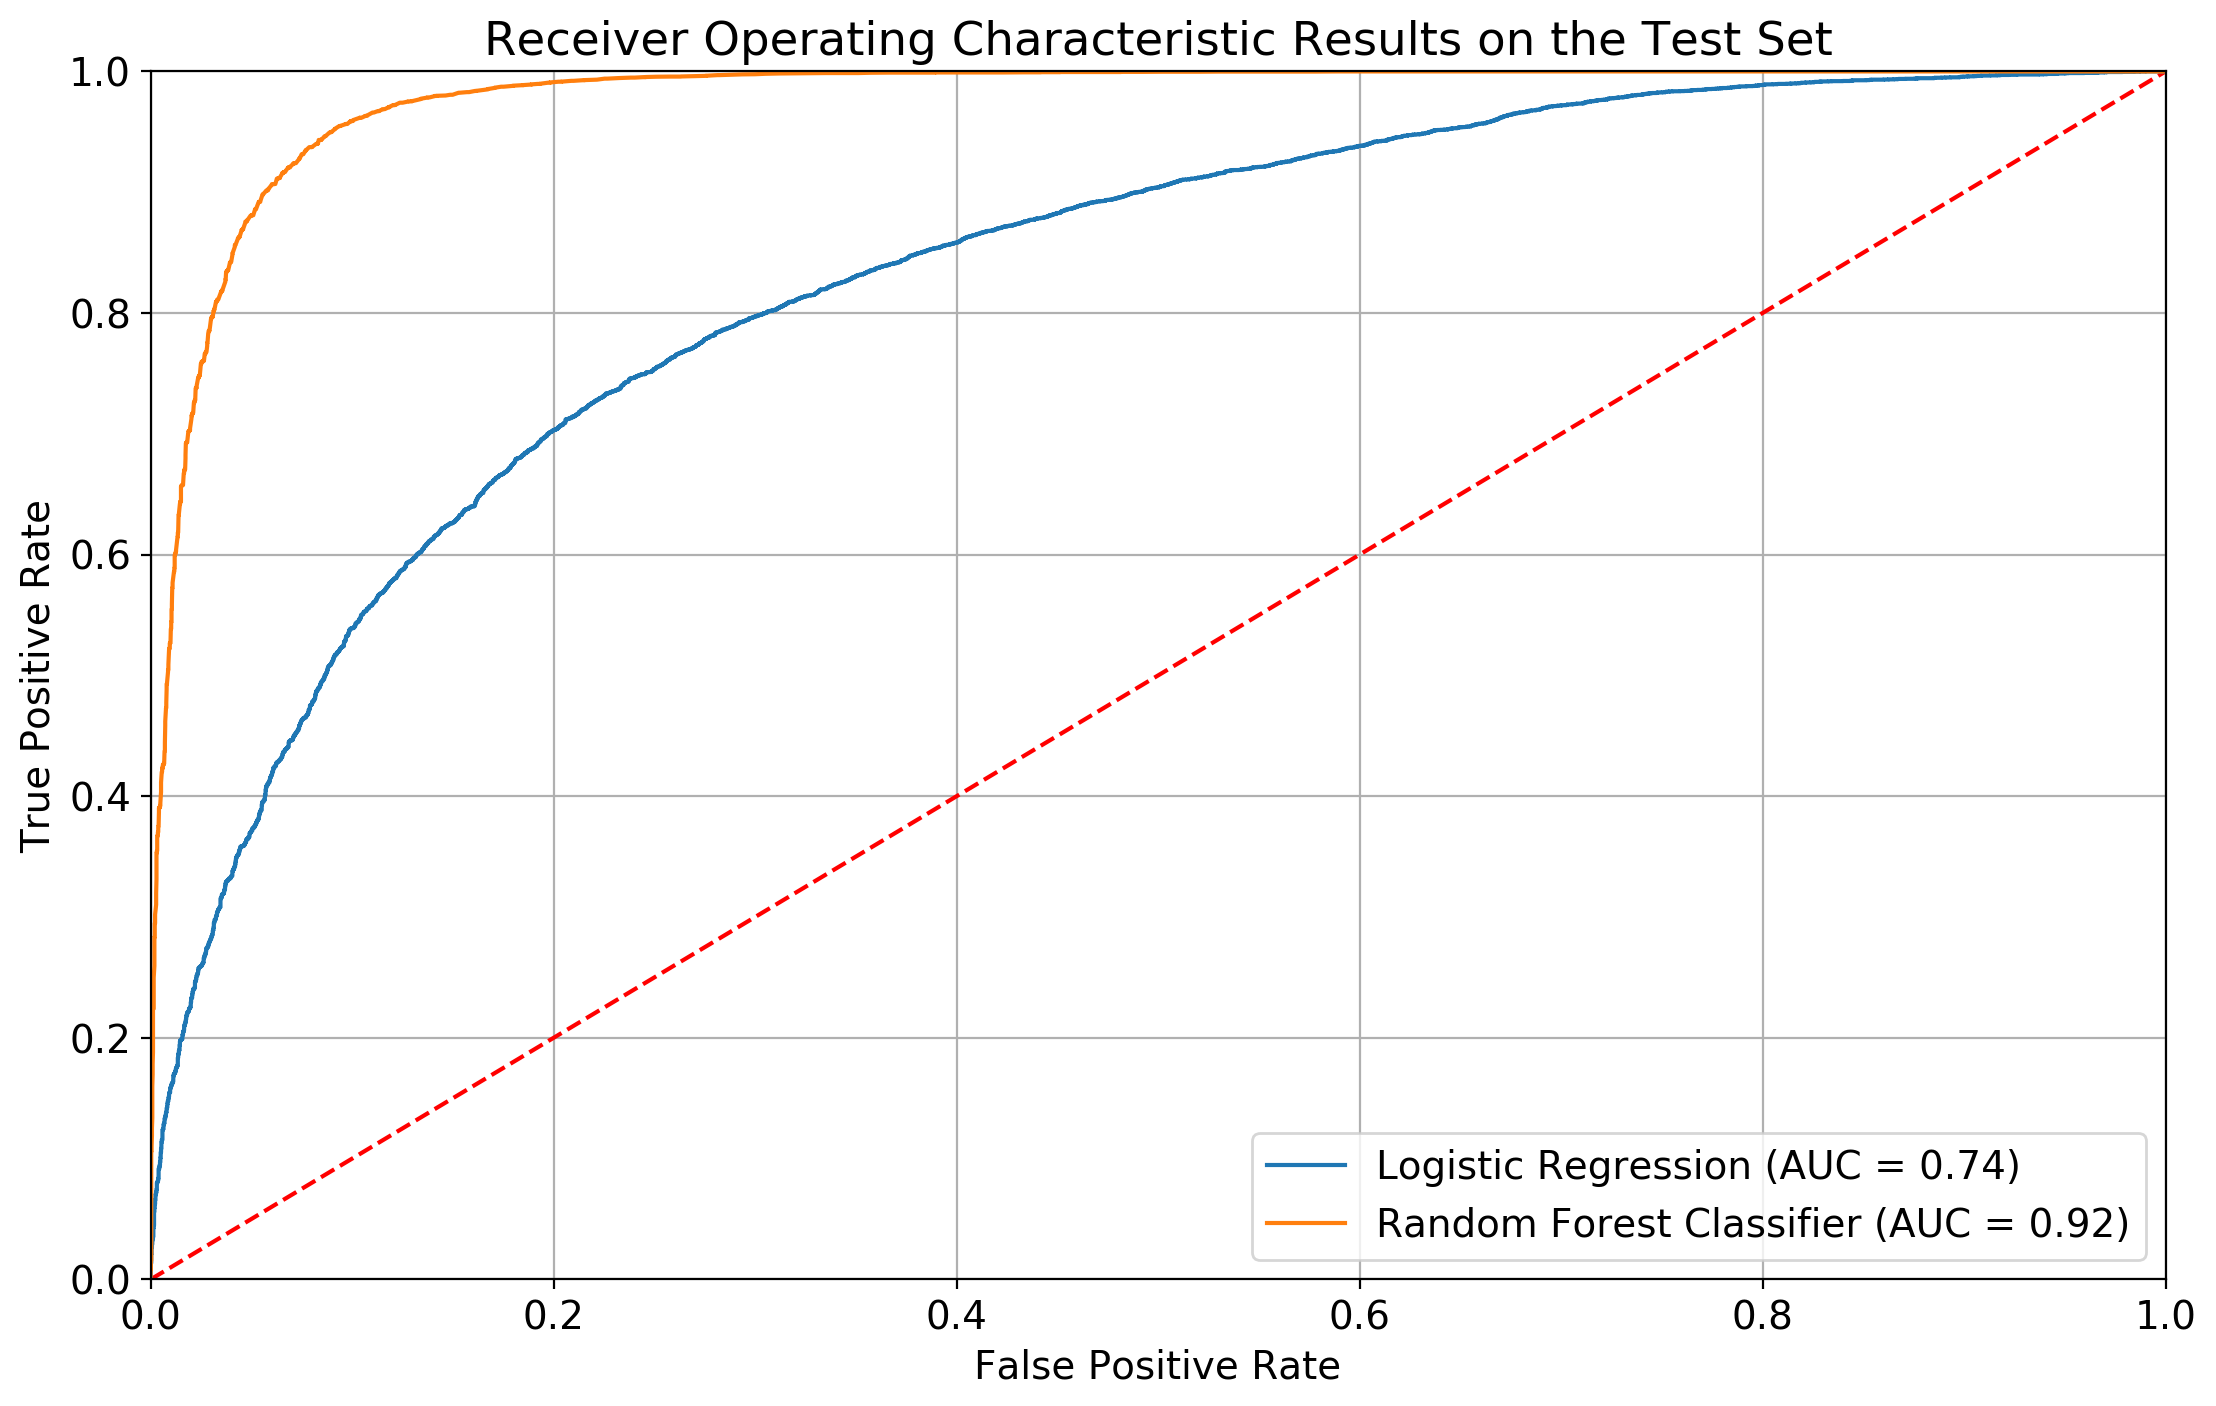

In [40]:
def ROC_plotter(models_dict, X_test, y_test):
    
    plt.figure(figsize = (13,8), dpi = 200)
    plt.title('Receiver Operating Characteristic Results on the Test Set')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    for model_name in models_dict.keys():
        model = models_dict[model_name]
        probs = model.predict_proba(X_test)
        preds = probs[:,1]
        fpr, tpr, threshold = roc_curve(y_test, preds)
        roc_auc = roc_auc_score(y_test, model.predict(X_test))
        plt.plot(fpr, tpr, label = f'{model_name} (AUC ={roc_auc: .2f})')
    
    plt.legend(loc = 'lower right')
    plt.show()

    return

ROC_plotter({'Logistic Regression':model, 'Random Forest Classifier':model2}, X_test, y_test)

The ROC curve comparison of the two models, again shows the significant superiority of the RF model at "all working points". The optimal classification boundary depends on the application of the classification score and the cost associated with sensitivity and specificity. For example, if the goal of the "is it going to rain?" classification is to determine when is the optimal time to "paint your garage door", you probably don't care as much about a false positive detection (i.e., predicting rain, but seeing no rain) as you care about a false negative detection (i.e., predicting no rain, but seeing rain)! In this case, we will move towards the upper right side of the ROC curve, where there is more emphasis on minimizing the false negative ratio (i.e., predicting no rain, but observing rain) at the cost of introducing more false positives. Such compromises are especially important in health-care and medical diagnostics applications.

### Exploratory analysis of feature importance ranking

It is interesting to evaluate which features are the most significant contributors to the overall classification. This helps us evaluate the efficiency of our engineered features. For this purpose, lets remove the PCA stage from the RF pipeline to preserve all dimensions (to facilitate feature interpretability), and re-train the RF model:

In [41]:
# Defining the pipeline
pipeline3 = Pipeline(steps=[('scl', StandardScaler()),
                           ('rf', RandomForestClassifier())])

# Cross validation
rf__n_estimators = [int(i) for i in np.linspace(100, 200, 3)]
rf__max_depth = [int(x) for x in np.linspace(10, 30, 3)]
parameters3 = {'rf__n_estimators': rf__n_estimators,
              'rf__max_depth': rf__max_depth}

# Scoring
scoring = {'AUC': make_scorer(roc_auc_score),
           'Accuracy': make_scorer(accuracy_score),
           'Precision': make_scorer(precision_score),
           'Recall': make_scorer(recall_score),
           'F1': make_scorer(f1_score)}

model3 = GridSearchCV(pipeline3, 
                     parameters3, 
                     cv = StratifiedKFold(n_splits=3),
                     refit='AUC',
                     scoring = scoring,
                     return_train_score=True)
model3.fit(X_train, 
           y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scl',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('rf',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                       

In [42]:
# extracting and printing feature importance rankings
feature_importance_vals = list(model3.best_estimator_.steps[-1][1].feature_importances_)
feature_importance_tuples = list(zip(X_train.columns, list(model3.best_estimator_.steps[-1][1].feature_importances_)))
feature_importance_sorted_args = np.argsort(feature_importance_vals)[::-1]
feature_importances = [feature_importance_tuples[int(i)] for i in feature_importance_sorted_args]
print('\033[1m\033[94mRanked feature importances in the classification:\033[0m')
pd.set_option('display.max_rows', 300)
print(pd.DataFrame(feature_importances, columns = ['feature', 'importance']))

Ranked feature importances in the classification:
                         feature  importance
0             temperature_mean_2    0.013108
1           weather_dim_2_mean_4    0.012024
2           weather_dim_4_mean_1    0.011567
3           weather_dim_2_mean_1    0.011290
4           weather_dim_2_mean_8    0.010622
5             temperature_mean_1    0.010515
6           weather_dim_2_mean_2    0.010513
7             temperature_mean_4    0.010053
8           weather_dim_3_mean_2    0.009947
9            temperature_mean_16    0.009782
10            temperature_mean_8    0.009297
11          weather_dim_4_mean_2    0.009121
12          weather_dim_0_mean_1    0.009003
13       weather_dim_4_mean_2048    0.007948
14        weather_dim_4_mean_512    0.007935
15       wind_direction_x_mean_8    0.007871
16        temperature_slope_2048    0.007855
17           pressure_slope_1024    0.007724
18            pressure_mean_2048    0.007709
19    wind_direction_y_mean_2048    0.007681
20   

Interestingly, the embedded weather history features are of the top most significant predictive features along with temperature features (The last number in each feature name represents its corresponding look-back window length in hours). The averaged embedded features are also within the top contributors! This validates the efficiency of feature averaging in the embedding layer to have an estimate of weather in the past N hours. On the bottom side of the list, wind_speed and direction short time variations seem to be the least important predictors of rain in the next 24 hours.

# V) Conclusions
In this project multiple pre-processing, training, and evaluation stages were implemented. Two classifiers, an LGR and an RF, were trained and their performances were evaluated. The bulk of the work went towards data pre-processing, denoising, and feature engineering. The engineered features seem to be among the most influential features contributin to the high accuracy of the trained models on the test set.